In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig

from transformers import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import textwrap
import math
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
clear_output()

In [2]:
df_train = pd.read_csv('/home/m_nsu/ICLR/Datasets/IMDB/train.csv')
df_val = pd.read_csv('/home/m_nsu/ICLR/Datasets/IMDB/val.csv')
df_test = pd.read_csv('/home/m_nsu/ICLR/Datasets/IMDB/test.csv')

In [3]:
df_train.dropna(inplace=True)

In [4]:
df_train.head()

,Unnamed: 0,review,sentiment
0,48539,This was a very funny movie not Oscarworthy bu...,0
1,26308,I know this film has had a fairly rough ride f...,0
2,14603,Being stuck in bed with the flu and feeling to...,1
3,45794,This isnt exactly a great film but I admire th...,0
4,21688,It is difficult to rate a writerdirectors firs...,1


In [22]:
MAX_LEN = 200
RANDOM_SEED = 42
device = torch.device(0)

In [23]:
PRE_TRAINED_MODEL_NAME = 'roberta-large'
config = RobertaConfig.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
clear_output()
print(device)

cuda:0


In [24]:
class IMDBDataset(Dataset):

  def __init__(self, reviews, sentiments, tokenizer, max_len):
    self.reviews = reviews
    self.sentiments = sentiments
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    sentiment = self.sentiments[item]


    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation = True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'sentiments': torch.tensor(sentiment, dtype=torch.long),

    }

In [25]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = IMDBDataset(
    reviews=df.review.to_numpy(),
    sentiments=df['sentiment'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=8
  )

In [26]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [27]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review', 'input_ids', 'attention_mask', 'sentiments'])

In [28]:
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()
    self.bert = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME,config=config)
    self.FC = nn.Linear(config.hidden_size,2, bias=False)


  def forward(self, input_ids, attention_mask):
    with torch.no_grad():
      pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask,
        return_dict = False
      )
    pooled_output = torch.mean(pooled_output[0], dim=1) # Taking Averge pooled last layer embedding

    binary_out = self.FC(pooled_output)
    
    return binary_out

In [29]:
model = Classifier()
model = model.to(device)
clear_output()

In [30]:
for name, param in model.named_parameters():
    if name.startswith('bert'):
        param.requires_grad = False

In [31]:
#for name, param in model.named_parameters():
#    print(name, param.requires_grad)

In [32]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
sentiments = data['sentiments'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 200])
torch.Size([32, 200])


In [33]:
#del test
torch.cuda.empty_cache()

In [34]:
outs = model(input_ids, attention_mask)

In [35]:
outs

tensor([[-0.7528,  0.6537],
        [-0.7695,  0.5806],
        [-0.7913,  0.5575],
        [-0.7840,  0.5914],
        [-0.7829,  0.5687],
        [-0.8008,  0.6121],
        [-0.7681,  0.6100],
        [-0.7864,  0.5589],
        [-0.7426,  0.5783],
        [-0.7371,  0.5387],
        [-0.7932,  0.5525],
        [-0.7728,  0.5873],
        [-0.8216,  0.5862],
        [-0.7651,  0.5535],
        [-0.8383,  0.5820],
        [-0.7597,  0.6138],
        [-0.8121,  0.5654],
        [-0.8729,  0.5414],
        [-0.8110,  0.5213],
        [-0.8057,  0.5856],
        [-0.7508,  0.5852],
        [-0.8092,  0.5742],
        [-0.7899,  0.6172],
        [-0.7634,  0.6138],
        [-0.7900,  0.5054],
        [-0.7907,  0.6035],
        [-0.7974,  0.5155],
        [-0.7545,  0.5729],
        [-0.7413,  0.5482],
        [-0.7482,  0.6084],
        [-0.7687,  0.5188],
        [-0.7727,  0.5884]], device='cuda:0', grad_fn=<MmBackward0>)

In [36]:
EPOCHS = 8

optimizer = AdamW(model.parameters(), lr=0.001)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=math.floor((1./5)*total_steps),
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [37]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    sentiments = d["sentiments"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    ).to(device)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, sentiments)

    correct_predictions += torch.sum(preds == sentiments)
    losses.append(loss.item())


    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [38]:
def eval_model(model, data_loader, loss_fn, device, n_examples, on_new=False):
  model = model.eval()

  losses = []
  f1s = []

  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      sentiments = d["sentiments"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
      ).to(device)
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, sentiments)

      correct_predictions += torch.sum(preds == sentiments)
      losses.append(loss.item())

      f1s.append(f1_score(sentiments.cpu(), preds.cpu(), average='macro'))

  return correct_predictions.double() / n_examples, np.mean(losses), np.mean(f1s)

In [39]:
%%time

train_a = []
train_l = []
val_a = []
val_l = []
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss, val_f1 = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  train_a.append(train_acc)
  train_l.append(train_loss)
  val_a.append(val_acc)
  val_l.append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'baseline_bert_best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/8
----------
Train loss 0.5224748132705689 accuracy 0.7841750000000001
Val   loss 0.3476291074874295 accuracy 0.8688

Epoch 2/8
----------
Train loss 0.297849018996954 accuracy 0.88365
Val   loss 0.28951823398186144 accuracy 0.8814000000000001

Epoch 3/8
----------
Train loss 0.26300194618701933 accuracy 0.894
Val   loss 0.274369531162795 accuracy 0.8874000000000001

Epoch 4/8
----------
Train loss 0.254089415243268 accuracy 0.8965000000000001
Val   loss 0.2619149535894394 accuracy 0.8918

Epoch 5/8
----------
Train loss 0.2481885947406292 accuracy 0.900225
Val   loss 0.25632380136543775 accuracy 0.8962

Epoch 6/8
----------
Train loss 0.24490812806487083 accuracy 0.9011750000000001
Val   loss 0.25351111716620484 accuracy 0.8976000000000001

Epoch 7/8
----------
Train loss 0.24209747795164585 accuracy 0.90375
Val   loss 0.2520762600574144 accuracy 0.8986000000000001

Epoch 8/8
----------
Train loss 0.2414363041251898 accuracy 0.9029
Val   loss 0.25222110926250746 accuracy 0.898

In [40]:
train_a = [i.item() for i in train_a]
train_l = [i.item() for i in train_l]
val_a = [i.item() for i in val_a]
val_l = [i.item() for i in val_l]

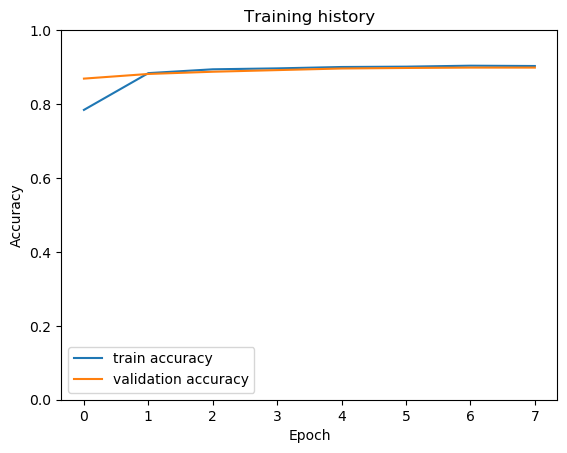

In [41]:
plt.plot(train_a, label='train accuracy')
plt.plot(val_a, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()

Accuracy of Pos/Neg on Test Set

In [42]:
import numpy as np
test_acc, _, test_f1 = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)


print("Accuracy: ",test_acc.item())
print("F1-Macro: ",test_f1.item())

Accuracy:  0.8974000000000001
F1-Macro:  0.8934379584843231


In [51]:
def get_predictions(model, data_loader):
  model = model.eval()

  review = []
  predictions = []

  prediction_probs = []
  real_values = []

  pos_scores = []
  neg_scores = []


  with torch.no_grad():
    for d in data_loader:

      reviews = d["review"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      sentiments = d["sentiments"].to(device)


      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
      )
      _, preds = torch.max(outputs, dim=1)


      probs = F.softmax(outputs, dim=1)

      review.extend(reviews)
      predictions.extend(preds)

      prediction_probs.extend(probs)
      real_values.extend(sentiments)

      pos_scores.extend(scores[0])
      neg_scores.extend(scores[1])


  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  pos_scores = torch.stack(pos_scores).cpu()
  neg_scores = torch.stack(neg_scores).cpu()
  return review, predictions, prediction_probs, real_values, pos_scores, neg_scores

In [52]:
y_review_texts, y_pred, y_pred_probs, y_test, pos_scores, neg_scores = get_predictions(
  model,
  test_data_loader
)

NameError: name 'scores' is not defined

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
class_names = ['negative', 'positive']

Pos/Neg Classification Report

In [50]:
print(classification_report(y_test, y_pred, target_names=class_names))

NameError: name 'classification_report' is not defined